In [1]:
import os
import os.path as osp
import sys
sys.path.insert(0, osp.dirname(osp.abspath('.')))

In [2]:
import torch
import torchvision.transforms as T

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from data.dataset import YOLODataset, PASCAL_CLASSES
from data.transform import get_yolo_transform

from utils.convert import cells_to_boxes, xywh2tlbr
from utils.cleanup import nms_by_class
from utils.display import draw_boxes

%load_ext autoreload
%autoreload 2

In [3]:
def init_random_seed():
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    
init_random_seed()

## Hyperparameters

In [4]:
CSV_PATH = "../download/PASCAL_VOC/test.csv"
IMG_DIR = "../download/PASCAL_VOC/images/"
LABEL_DIR = "../download/PASCAL_VOC/labels/"

In [5]:
IMG_SIZE = 416
SCALES = [13, 26, 52]
ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
] # (3, 3, 2)

## Prepare Dataset

In [6]:
inverse = T.ToPILImage()

In [7]:
transform = get_yolo_transform(img_size=IMG_SIZE, mode='test')
dataset = YOLODataset(csv_file=CSV_PATH,
                      img_dir=IMG_DIR,
                      label_dir=LABEL_DIR,
                      anchors=ANCHORS,
                      transform=transform)

In [8]:
print("Number of samples:", len(dataset))

Number of samples: 4951


## Random Sampling Input Data

In [9]:
scales = torch.tensor(SCALES).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2) # (3, 3, 2)
scaled_anchors = torch.tensor(ANCHORS)*scales # (3, 3, 2)

In [10]:
# Random select indices from datase 
indices = np.arange(0, len(dataset))
sample_indices = np.random.choice(indices, 9, replace=False)

In [11]:
candidates = []
for sample_idx in sample_indices:
    # Read sample
    bboxes = []
    img, targets = dataset[sample_idx]
    for scale_idx, scale in enumerate(SCALES):
        # Convert bounding boxes to normalized format (xywh)
        targets_in_scale = targets[scale_idx]
        cell_boxes = cells_to_boxes(targets_in_scale.unsqueeze(0), scale=scale)
        obj_mask = cell_boxes[..., 4] == 1.
        boxes = cell_boxes[obj_mask]
        bboxes.append(boxes)
    # Collect sample
    bboxes = torch.cat(bboxes, dim=0)
    candidates.append((img, bboxes))

## Extract possible object proposals & Perform NMS per class

In [12]:
truth = []
for candidate in candidates:
    img = candidate[0]
    bboxes = candidate[1]
    nms_boxes = []
    # Perform NMS on each class
    for c, name in enumerate(PASCAL_CLASSES):
        boxes = nms_by_class(bboxes, target=c, iou_threshold=0.45)
        nms_boxes.extend(boxes)
    # Convert normalized coordinate to image coordinate
    nms_boxes = torch.tensor(nms_boxes)
    nms_boxes[..., :4] *= IMG_SIZE
    truth.append((img, nms_boxes.tolist()))

## Plot bounding boxes on image

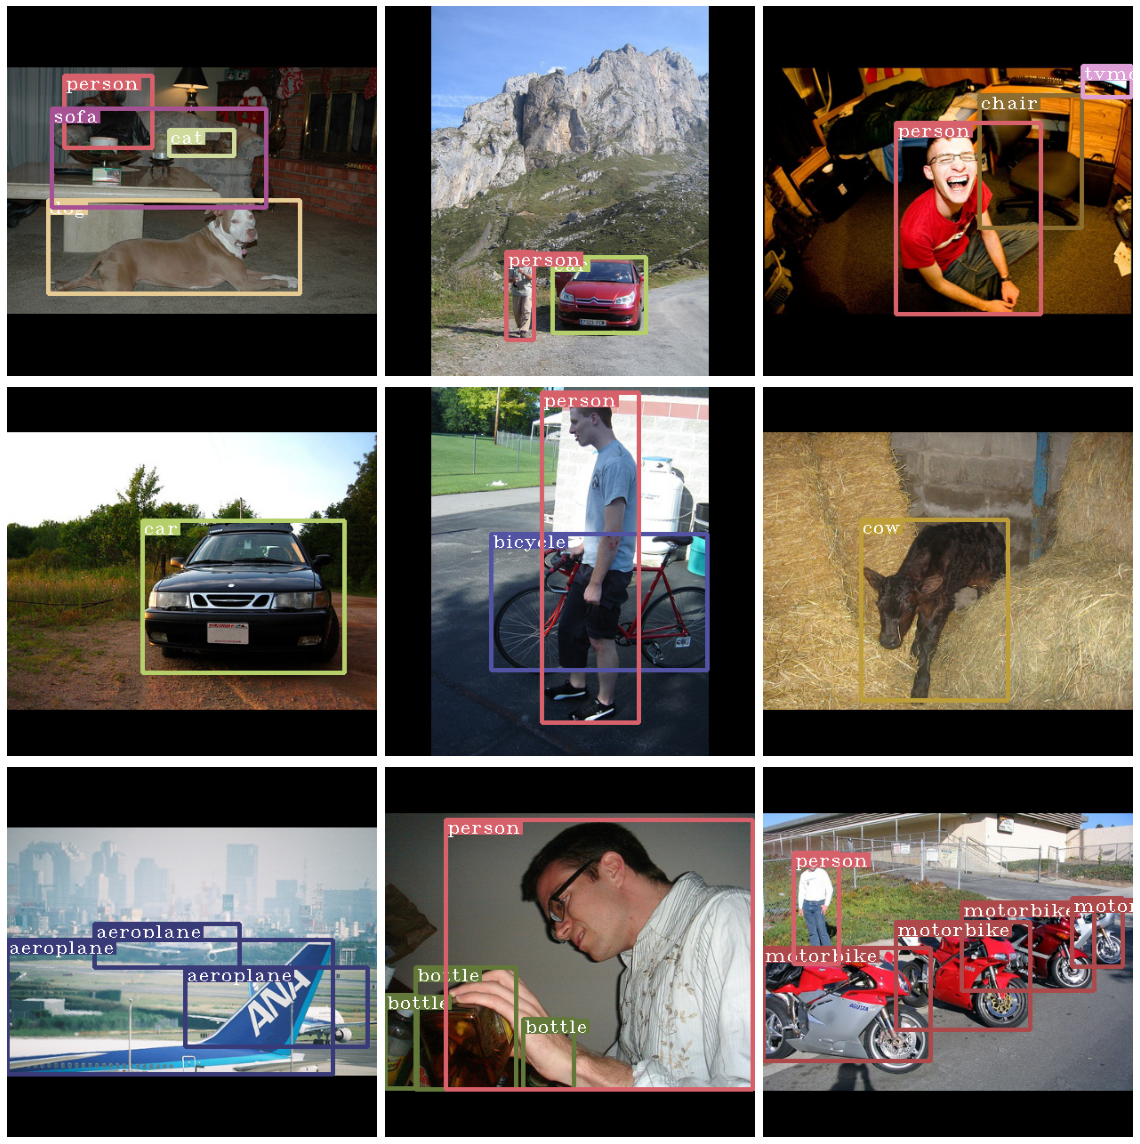

In [13]:
nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
for i in range(nrows):
    for j in range(ncols):
        idx = i*ncols + j
        img, bboxes = truth[idx]
        # Convert image to numpy array
        frame = np.array(inverse(img))
        # Draw bounding boxes on image
        draw_boxes(frame, bboxes, PASCAL_CLASSES)
        axes[i][j].imshow(frame)
        axes[i][j].set_axis_off()
        
plt.tight_layout()